https://turing.ml/dev/tutorials/02-logistic-regression/

In [1]:
ENV["COLUMNS"], ENV["LINES"] = 100, 30;

In [2]:
VERSION

v"1.7.2"

In [3]:
]st Turing Distributions RDatasets MCMCChains Plots StatsPlots StatsFuns MLDataUtils 

      Status `D:\.julia\environments\v1.7\Project.toml`
  [31c24e10] Distributions v0.25.59
  [c7f686f2] MCMCChains v5.3.0
  [cc2ba9b6] MLDataUtils v0.5.4
  [91a5bcdd] Plots v1.29.0
  [ce6b1742] RDatasets v0.7.7
  [4c63d2b9] StatsFuns v1.0.1
  [f3b207a7] StatsPlots v0.14.34
  [fce5fe82] Turing v0.21.2


In [4]:
# Import Turing and Distributions.
using Turing, Distributions

# Import RDatasets.
using RDatasets

# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

# Functionality for splitting and normalizing the data
using MLDataUtils: shuffleobs, stratifiedobs, rescale!

# Set a seed for reproducibility.
using Random
Random.seed!(0);

# Turn off progress monitor.
Turing.setprogress!(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing D:\.julia\packages\Turing\PHMcO\src\Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI D:\.julia\packages\AdvancedVI\W2zsz\src\AdvancedVI.jl:15


false

In [5]:
# Import the "Default" dataset.
data = RDatasets.dataset("ISLR", "Default");

# Show the first six rows of the dataset.
first(data, 6)

,Default,Student,Balance,Income
,Cat…,Cat…,Float64,Float64
1,No,No,729.526,44361.6
2,No,Yes,817.18,12106.1
3,No,No,1073.55,31767.1
4,No,No,529.251,35704.5
5,No,No,785.656,38463.5
6,No,Yes,919.589,7491.56


In [6]:
# Convert "Default" and "Student" to numeric values.
data[!, :DefaultNum] = [r.Default == "Yes" ? 1.0 : 0.0 for r in eachrow(data)]
data[!, :StudentNum] = [r.Student == "Yes" ? 1.0 : 0.0 for r in eachrow(data)]

# Delete the old columns which say "Yes" and "No".
select!(data, Not([:Default, :Student]))

# Show the first six rows of our edited dataset.
first(data, 6)

,Balance,Income,DefaultNum,StudentNum
,Float64,Float64,Float64,Float64
1,729.526,44361.6,0.0,0.0
2,817.18,12106.1,0.0,1.0
3,1073.55,31767.1,0.0,0.0
4,529.251,35704.5,0.0,0.0
5,785.656,38463.5,0.0,0.0
6,919.589,7491.56,0.0,1.0


In [7]:
function split_data(df, target; at=0.70)
    shuffled = shuffleobs(df)
    return trainset, testset = stratifiedobs(row -> row[target], shuffled; p=at)
end

features = [:StudentNum, :Balance, :Income]
numerics = [:Balance, :Income]
target = :DefaultNum

trainset, testset = split_data(data, target; at=0.05)
for feature in numerics
    μ, σ = rescale!(trainset[!, feature]; obsdim=1)
    rescale!(testset[!, feature], μ, σ; obsdim=1)
end

# Turing requires data in matrix form, not dataframe
train = Matrix(trainset[:, features])
test = Matrix(testset[:, features])
train_label = trainset[:, target]
test_label = testset[:, target];

In [8]:
# Bayesian logistic regression (LR)
@model function logistic_regression(x, y, n, σ)
    intercept ~ Normal(0, σ)

    student ~ Normal(0, σ)
    balance ~ Normal(0, σ)
    income ~ Normal(0, σ)

    for i in 1:n
        v = logistic(intercept + student * x[i, 1] + balance * x[i, 2] + income * x[i, 3])
        y[i] ~ Bernoulli(v)
    end
end;

In [9]:
# Retrieve the number of observations.
n, _ = size(train)

# Sample using HMC.
m = logistic_regression(train, train_label, n, 1)
chain = sample(m, HMC(0.05, 10), MCMCThreads(), 1_500, 3)

Chains MCMC chain (1500×13×3 Array{Float64, 3}):

Iterations        = 1:1:1500
Number of chains  = 3
Samples per chain = 1500
Wall duration     = 9.59 seconds
Compute duration  = 28.57 seconds
parameters        = intercept, student, balance, income
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64       Float64 

   intercept   -4.4178    0.4985     0.0074    0.0160   1036.1053    1.0023       36.2693
     student   -0.4273    0.6317     0.0094    0.0247    523.1121    1.0120       18.3118
     balance    1.8630    0.3221     0.0048    0.0077   1728.3165    1.0024       60.5005
      income    0.2812    0.3255     0.0049    0.0093   1047.6257    1.0065       36.6726

Quantiles
  parameters      2.5%     25.0%

In [10]:
describe(chain)

2-element Vector{ChainDataFrame}:
 Summary Statistics (4 x 8)
 Quantiles (4 x 6)

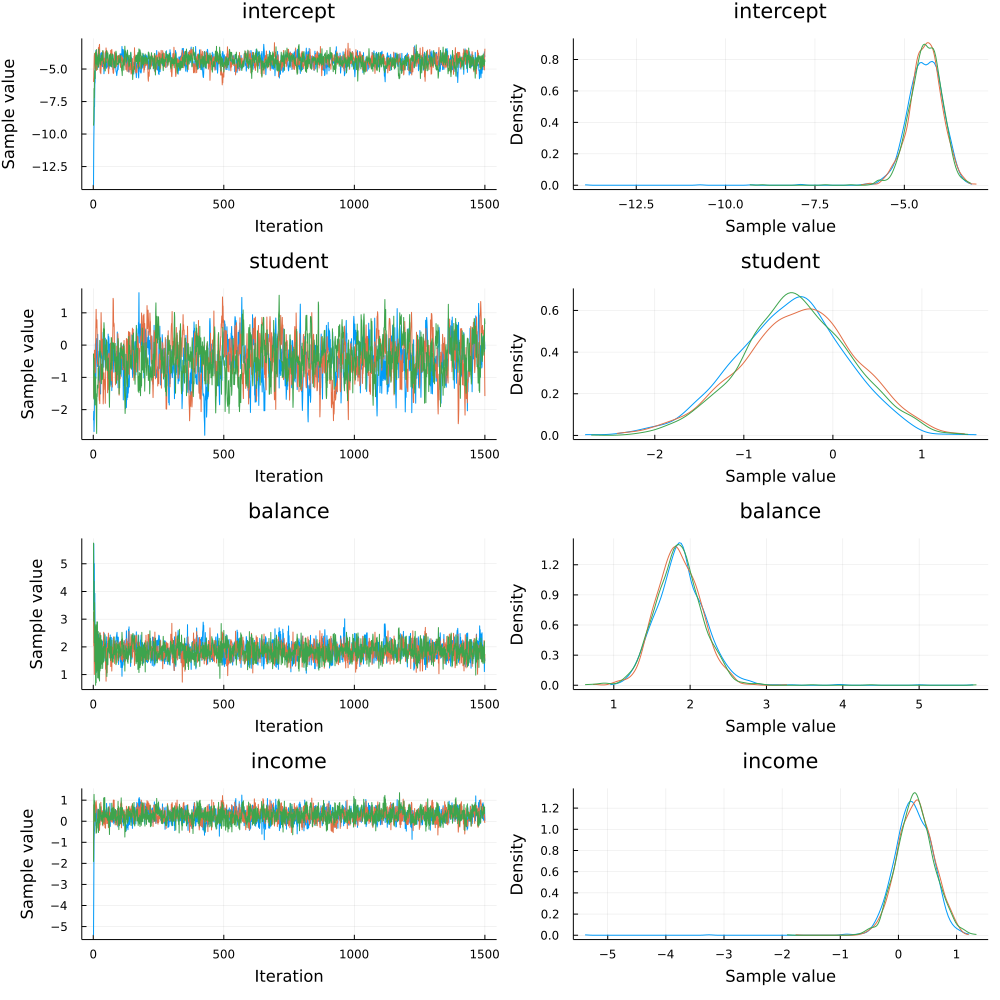

In [11]:
plot(chain)

In [12]:
# The labels to use.
l = [:student, :balance, :income]

# Use the corner function. Requires StatsPlots and MCMCChains.
corner(chain, l)

In [13]:
function prediction(x::Matrix, chain, threshold)
    # Pull the means from each parameter's sampled values in the chain.
    intercept = mean(chain[:intercept])
    student = mean(chain[:student])
    balance = mean(chain[:balance])
    income = mean(chain[:income])

    # Retrieve the number of rows.
    n, _ = size(x)

    # Generate a vector to store our predictions.
    v = Vector{Float64}(undef, n)

    # Calculate the logistic function for each element in the test set.
    for i in 1:n
        num = logistic(
            intercept .+ student * x[i, 1] + balance * x[i, 2] + income * x[i, 3]
        )
        if num >= threshold
            v[i] = 1
        else
            v[i] = 0
        end
    end
    return v
end;

In [14]:
# Set the prediction threshold.
threshold = 0.07

# Make the predictions.
predictions = prediction(test, chain, threshold)

# Calculate MSE for our test set.
loss = sum((predictions - test_label) .^ 2) / length(test_label)

0.12905263157894736

In [15]:
defaults = sum(test_label)
not_defaults = length(test_label) - defaults

predicted_defaults = sum(test_label .== predictions .== 1)
predicted_not_defaults = sum(test_label .== predictions .== 0)

println("Defaults: $defaults
    Predictions: $predicted_defaults
    Percentage defaults correct $(predicted_defaults/defaults)")

println("Not defaults: $not_defaults
    Predictions: $predicted_not_defaults
    Percentage non-defaults correct $(predicted_not_defaults/not_defaults)")

Defaults: 316.0
    Predictions: 270
    Percentage defaults correct 0.8544303797468354
Not defaults: 9184.0
    Predictions: 8004
    Percentage non-defaults correct 0.8715156794425087


---

In [16]:
names(chain)

13-element Vector{Symbol}:
 :intercept
 :student
 :balance
 :income
 :lp
 :n_steps
 :is_accept
 :acceptance_rate
 :log_density
 :hamiltonian_energy
 :hamiltonian_energy_error
 :step_size
 :nom_step_size

In [17]:
intercept = chain[:intercept]
intercept[1:5, :]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:5
    :chain, 1:3
And data, a 5×3 Matrix{Float64}:
 -13.9392   -5.9888   -9.35209
 -10.7115   -5.62741  -8.97752
  -9.26447  -4.78482  -6.49479
  -7.90822  -4.00305  -7.2044
  -7.88832  -3.79969  -5.13466

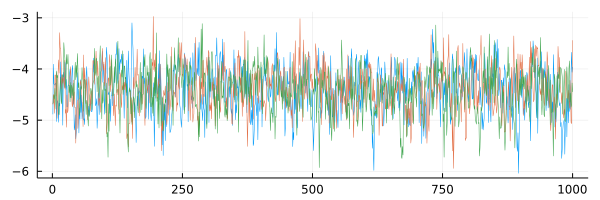

In [18]:
plot(intercept[501:1500, :]; lw=0.5, label=false, size=(600, 200))

---

In [19]:
desc = describe(chain)

2-element Vector{ChainDataFrame}:
 Summary Statistics (4 x 8)
 Quantiles (4 x 6)

In [20]:
S = desc[1]

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64       Float64 

   intercept   -4.4178    0.4985     0.0074    0.0160   1036.1053    1.0023       36.2693
     student   -0.4273    0.6317     0.0094    0.0247    523.1121    1.0120       18.3118
     balance    1.8630    0.3221     0.0048    0.0077   1728.3165    1.0024       60.5005
      income    0.2812    0.3255     0.0049    0.0093   1047.6257    1.0065       36.6726


In [21]:
convert(Array, S)

4×7 Matrix{Float64}:
 -4.41785   0.498471  0.00743076  0.01598     1036.11   1.00232  36.2693
 -0.427311  0.631668  0.00941635  0.0247313    523.112  1.01197  18.3118
  1.86296   0.32209   0.00480143  0.00774604  1728.32   1.00236  60.5005
  0.281203  0.325521  0.00485259  0.00928872  1047.63   1.00646  36.6726

In [22]:
names(S)

8-element Vector{Symbol}:
 :parameters
 :mean
 :std
 :naive_se
 :mcse
 :ess
 :rhat
 :ess_per_sec

In [23]:
dump(S)

ChainDataFrame{NamedTuple{(:parameters, :mean, :std, :naive_se, :mcse, :ess, :rhat, :ess_per_sec), Tuple{Vector{Symbol}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}}}}
  name: String "Summary Statistics"
  nt: NamedTuple{(:parameters, :mean, :std, :naive_se, :mcse, :ess, :rhat, :ess_per_sec), Tuple{Vector{Symbol}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}}}
    parameters: Array{Symbol}((4,))
      1: Symbol intercept
      2: Symbol student
      3: Symbol balance
      4: Symbol income
    mean: Array{Float64}((4,)) [-4.417849563368747, -0.42731083594798247, 1.862964765702687, 0.28120259765868516]
    std: Array{Float64}((4,)) [0.4984708546969706, 0.6316679448575059, 0.3220898394109102, 0.32552139969292926]
    naive_se: Array{Float64}((4,)) [0.007430764772698977, 0.009416349759393147, 0.00480143183856524, 0.0048525865189617936]
    mcs

In [24]:
S.nt[:parameters]

4-element Vector{Symbol}:
 :intercept
 :student
 :balance
 :income

In [25]:
S.nt[:mean]

4-element Vector{Float64}:
 -4.417849563368747
 -0.42731083594798247
  1.862964765702687
  0.28120259765868516